In [ ]:
%%capture
!pip install sentence-transformers openai matplotlib seaborn -q


In [ ]:
from google.colab import drive

from huggingface_hub import notebook_login

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import openai

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# Request access to drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the dataset
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Comparing Transformer models/preprocessed_jobstreet_dataset.csv')

dataset

,job_title,descriptions,cleaned_description,cleaned_title
0,Procurement Executive (Contract),Position Purpose\nManage aspects of procuremen...,position purpose manage aspect procurement inc...,procurement executive contract
1,Account Executive/ Assistant,We are looking for a Account Executive/ Assist...,looking account assistant join team get join u...,account assistant
2,"Data Analyst - Asset Management, SPX Express",Performs detailed data analysis on existing sp...,performs detailed data analysis existing spend...,data analyst asset management spx express
3,Service Engineer,"You are important for troubleshooting, install...",important troubleshooting installation mainten...,service engineer
4,Purchasing Executive,"MAG is a trailblazer in the industry, boasting...",mag trailblazer industry boasting extensive tr...,purchasing executive
...,...,...,...,...
59301,"Marketing Specialist, APAC",MAIN RESPONSIBILITIES\nSupport the Asia Pacifi...,main responsibility support asia pacific sale ...,marketing specialist apac
59302,Talent Acquisition Partner,Job Descriptions:\nPartner closely with HRBPs ...,job description partner closely hrbps hiring m...,talent acquisition partner
59303,Motor Insurance Executive,Objective:\nHighly motivated and customer-focu...,objective highly motivated motor insurance exe...,motor insurance executive
59304,Banca Specialist (Klang Valley),Job Descriptions:\nDelivers sales target for b...,job description delivers sale target bancassur...,banca specialist klang valley


In [ ]:
# Fill missing values in the "description" column with an empty string
dataset["cleaned_description"] = dataset["cleaned_description"].fillna("")

# Ensure all values are strings
dataset["cleaned_description"] = dataset["cleaned_description"].astype(str)

# Combine titles and descriptions into a single column
dataset["combined"] = dataset["cleaned_title"] + " " + dataset["cleaned_description"]

# Convert combined column to a list
titles = dataset["cleaned_title"]
description = dataset["cleaned_description"]
combined = dataset["combined"].astype(str)

# Preview an entry
print(f"Example combined entry: {dataset['combined'].iloc[0]}")

Example combined entry: procurement executive contract position purpose manage aspect procurement including supplier management contract management vendor performance tracking support administration management procurement process includes setting maintaining administering purchasing database developing issuing purchase order maintain contract log providing support department within organization involved procurement key duty responsibility general ensure po created following bidding requirement oa update time time upon request planning team buyer geographical coverage malaysia singapore operation ensure purchasing activity comply procurement procedure company internal policy actively seek opportunity improvement way thing better lead implementation action defined manage report review manage report review weekly monthly quarterly accordingly contract log update ensure expiring expired contract renewed time safekeeping contract softcopy active inactive vendor code cleansing quarterly basi

In [ ]:
competences = [
    "Knowledge representation and reasoning",
    "Automated planning and scheduling",
    "Machine learning",
    "Natural language processing",
    "Machine perception",
    "Computer vision",
    "Speech recognition",
    "Robotics",
    "Affective computing",
    "Deep learning",
    "Information retrieval",
    "Computer science",
    "Causality",
    "Data mining",
    "Commonsense knowledge",
    "Intelligent agents",
    "Generative AI",
    "Large Language Models",
]

In [ ]:
# embedding models
models = {
    "E5-large": SentenceTransformer("intfloat/e5-large-v2"),
}


In [ ]:
# Pre-calculate embeddings for job postings
job_postings_embeddings = {
    model_name: model.encode(combined, convert_to_numpy=True, show_progress_bar=True)
    for model_name, model in models.items()
}

# Generate embeddings for competences
competences_embeddings = {
    model_name: {
        competence: model.encode(competence, convert_to_numpy=True)
        for competence in competences
    }
    for model_name, model in models.items()
}


Batches:   0%|          | 0/1854 [00:00<?, ?it/s]

In [ ]:
# Compute similarity scores
similarity_scores = {
    model_name: {
        competence: cosine_similarity(job_postings_embeddings[model_name],
                                       np.array([embedding])).flatten()
        for competence, embedding in competence_embeddings.items()
    }
    for model_name, competence_embeddings in competences_embeddings.items()
}

In [ ]:
# Aggregate results and rank competences for each job posting
ranked_scores = {
    model_name: {
        job_idx: sorted(
            [(competence, scores[job_idx]) for competence, scores in model_scores.items()],
            key=lambda x: x[1],
            reverse=True
        )
        for job_idx in range(job_postings_embeddings[model_name].shape[0])
    }
    for model_name, model_scores in similarity_scores.items()
}

# Compute average scores for each competence group
avg_scores = {
    model_name: {
        competence: np.mean(scores)
        for competence, scores in model_scores.items()
    }
    for model_name, model_scores in similarity_scores.items()
}

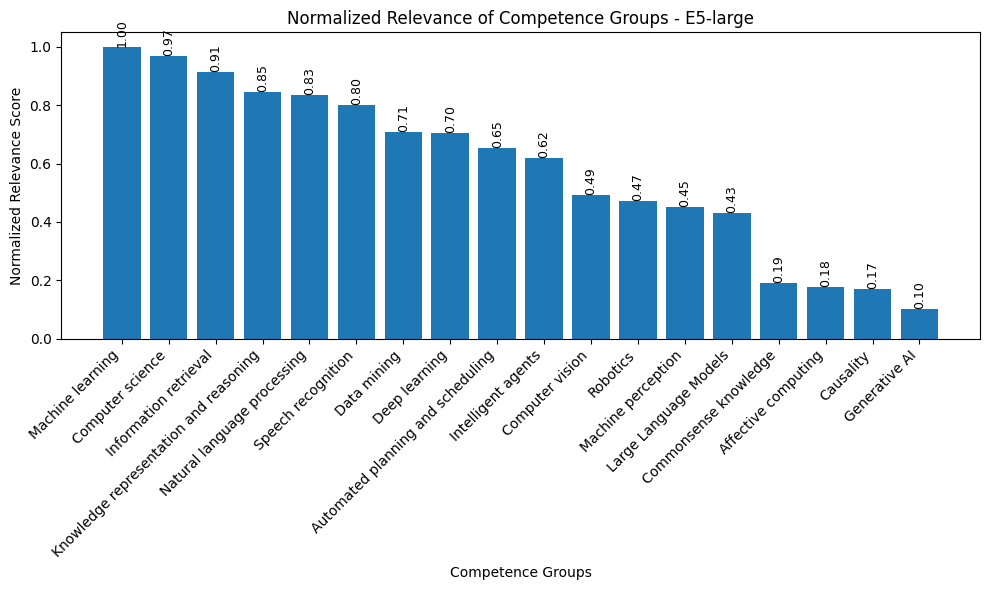

In [ ]:
# Normalize scores to a scale of 1 to 0.1
def normalize_scores(scores, min_value=0.1, max_value=1.0):
  min_score = min(scores.values())
  max_score = max(scores.values())
  return {key: min_value + (value - min_score) * (max_value - min_value) / (max_score - min_score)
          for key, value in scores.items()}

for model_name, scores in avg_scores.items():
  # Normalize the scores
  normalized_scores = normalize_scores(scores, min_value=0.1, max_value=1.0)

  # Sort normalized scores for plotting
  sorted_scores = dict(sorted(normalized_scores.items(), key=lambda x: x[1], reverse=True))

  # Plot the scores
  plt.figure(figsize=(10, 6))
  plt.bar(sorted_scores.keys(), sorted_scores.values())
  plt.xlabel("Competence Groups")
  plt.ylabel("Normalized Relevance Score")
  plt.title(f"Normalized Relevance of Competence Groups - {model_name}")
  plt.xticks(rotation=45, ha="right")

  # Annotate bars with normalized scores
  for i, (key, value) in enumerate(sorted_scores.items()):
      plt.text(i, value, f"{value:.2f}", ha='center', va='bottom', fontsize=9, rotation=90)

  plt.tight_layout()
  plt.show()

In [ ]:
# Normalize scores to a scale of 1 to 0.1
def normalize_scores(scores, min_value=0.1, max_value=1.0):
    min_score = min(scores.values())
    max_score = max(scores.values())
    return {key: min_value + (value - min_score) * (max_value - min_value) / (max_score - min_score)
            for key, value in scores.items()}

# Example: Loop through models and compute normalized scores
for model_name, scores in avg_scores.items():
    # Normalize the scores
    normalized_scores = normalize_scores(scores, min_value=0.1, max_value=1.0)

    # Print normalized scores
    print(f"\nNormalized Scores for {model_name}:")
    for competence_group, score in normalized_scores.items():
        print(f"{competence_group}: {score:.2f}")


Normalized Scores for E5-large:
Knowledge representation and reasoning: 0.85
Automated planning and scheduling: 0.65
Machine learning: 1.00
Natural language processing: 0.83
Machine perception: 0.45
Computer vision: 0.49
Speech recognition: 0.80
Robotics: 0.47
Affective computing: 0.18
Deep learning: 0.70
Information retrieval: 0.91
Computer science: 0.97
Causality: 0.17
Data mining: 0.71
Commonsense knowledge: 0.19
Intelligent agents: 0.62
Generative AI: 0.10
Large Language Models: 0.43


In [ ]:
# Data for the spider plot
datasets = {
    "AI Jobs Dataset": {
        "Knowledge representation and reasoning": 0.64,
        "Automated planning and scheduling": 0.54,
        "Machine learning": 1.00,
        "Natural language processing": 0.82,
        "Machine perception": 0.48,
        "Computer vision": 0.51,
        "Speech recognition": 0.63,
        "Robotics": 0.41,
        "Affective computing": 0.26,
        "Deep learning": 0.74,
        "Information retrieval": 0.72,
        "Computer science": 0.88,
        "Causality": 0.12,
        "Data mining": 0.69,
        "Commonsense knowledge": 0.10,
        "Intelligent agents": 0.50,
        "Generative AI": 0.40,
        "Large Language Models": 0.52,
    },
    "All Jobs USA Dataset": {
        "Knowledge\nrepresentation and reasoning": 0.77,
        "Automated\n planning and scheduling": 0.65,
        "Machine\n learning": 1.00,
        "Natural language\n processing": 0.84,
        "Machine perception": 0.44,
        "Computer vision": 0.50,
        "Speech recognition": 0.76,
        "Robotics": 0.46,
        "Affective computing": 0.10,
        "Deep learning": 0.72,
        "Information\n retrieval": 0.93,
        "Computer\n science": 0.89,
        "Causality": 0.19,
        "Data mining": 0.63,
        "Commonsense\n knowledge": 0.15,
        "Intelligent agents": 0.53,
        "Generative AI": 0.11,
        "Large\n Language Models": 0.44,
    },
    "All Jobs Asia Dataset":{
        "Knowledge\nrepresentation and reasoning": 0.85,
        "Automated\n planning and scheduling": 0.65,
        "Machine\n learning": 1.00,
        "Natural language\n processing": 0.83,
        "Machine perception": 0.45,
        "Computer vision": 0.49,
        "Speech recognition": 0.80,
        "Robotics": 0.47,
        "Affective computing": 0.18,
        "Deep learning": 0.70,
        "Information\n retrieval": 0.91,
        "Computer\n science": 0.97,
        "Causality": 0.17,
        "Data mining": 0.71,
        "Commonsense\n knowledge": 0.19,
        "Intelligent agents": 0.62,
        "Generative AI": 0.10,
        "Large\n Language Models": 0.43,
    },
    "Baseline results 2022": {
        "Knowledge representation and reasoning": 0.62,
        "Automated planning and scheduling": 0.57,
        "Machine learning": 1.00,
        "Natural language processing": 0.35,
        "Machine perception": 0.60,
        "Computer vision": 0.50,
        "Speech recognition": 0.40,
        "Robotics": 0.45,
        "Affective computing": 0.78,
        "Deep learning": 0.43,
        "Information retrieval": 0.40,
        "Computer science": 0.32,
        "Causality": 0.10,
        "Data mining": 0.62,
        "Commonsense knowledge": 0.1,
        "Intelligent agents": 0.87,
    }
}


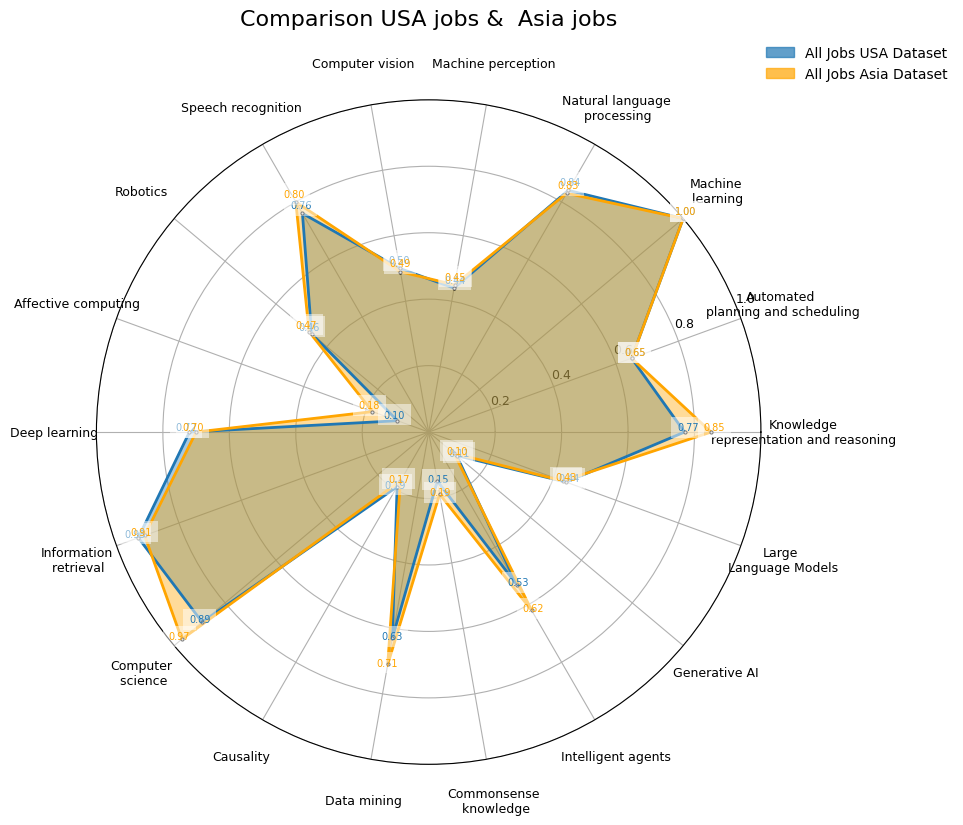

In [ ]:
import matplotlib.patches as mpatches

# Competence groups
competence_groups = list(datasets["All Jobs USA Dataset"].keys())

# Scores for each dataset
scores_1 = list(datasets["AI Jobs Dataset"].values())
scores_2 = list(datasets["All Jobs USA Dataset"].values())
scores_3 = list(datasets["All Jobs Asia Dataset"].values())
scores_4 = list(datasets["Baseline results 2022"].values())

# Function to create the spider plot with proper label layering
def create_labelled_spider_plot(scores_list, competence_groups, labels, colors):
    num_vars = len(competence_groups)

    # Create angles for the radar chart
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Close the circle

    # Initialize spider plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    ax.set_facecolor('white')  # Set axis background to white

    # Plot each dataset with custom colors
    for scores, label, color in zip(scores_list, labels, colors):
        scores += scores[:1]  # Close the circle
        ax.plot(angles, scores, color=color, linewidth=2, linestyle='solid', label=label, zorder=5)
        ax.fill(angles, scores, color=color, alpha=0.4, zorder=3)  # More opaque fill

        # Plot small, light grey dots at each data point
        ax.scatter(angles[:-1], scores[:-1], color='lightgrey', edgecolor='black', linewidth=0.75, s=5, zorder=6)

        # Annotate the scores above the dots
        for angle, score in zip(angles, scores[:-1]):
            ax.text(
                angle, score + 0.01,  # Adjust vertical position for better clarity
                f"{score:.2f}",  # Format the score
                fontsize=7, color=color, ha='center', va='bottom',
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'),
                zorder=7  # Higher z-order to place above dots
            )

    # Set the labels for each angle with **highest zorder**
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(competence_groups, fontsize=9, wrap=True, color='black', ha='center')

    # Adjust position of labels
    ax.tick_params(axis='x', pad=20)

    # Enforce zorder for each xtick label after setting them
    for label in ax.get_xticklabels():
        label.set_zorder(50)  # Ensure highest zorder for text

    # Fixed radial grid
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([f"{y:.1f}" for y in [0.2, 0.4, 0.6, 0.8, 1.0]], fontsize=9, color='black')
    ax.set_ylim(0, 1.0)

    # Add a legend with a border
    # Add a custom legend with rectangle patches
    legend_patches = [mpatches.Patch(color=color, label=label, alpha=0.7) for label, color in zip(labels, colors)]
    legend = ax.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.3, 1.1), frameon=False, fontsize=10)

    # Set the title
    plt.title("Comparison USA jobs &  Asia jobs", size=16, y=1.1, color='black')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the function with adjusted colors, dots, and styling
create_labelled_spider_plot(
    scores_list=[scores_2, scores_3],
    competence_groups=competence_groups,
    labels= ["All Jobs USA Dataset","All Jobs Asia Dataset"],
    colors=["#1f77b4","#FFA500"]
)

# AI = purple, full set = "#1f77b4", baseline = "red", asia = "#FFA500"